Learn iterator for multiphase elastic problems using SAC-FEANet

In [1]:
import pacnet.pac as pac

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
from functools import reduce

from utils import plot
from feanet.model import PACFEANet
from feanet.jacobi import JacobiBlock
from data.dataset import ElasticityDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    '''
    def __init__(self, size, n_elem, mode, iterator='jacobi'):
        self.size = size # actual size of the plate
        self.mode = mode
        self.n_elem = n_elem
        self.h = size/n_elem
        self.net = self.InstantiateNetwork()
        self.iterator = None
        if(iterator == 'jacobi'):
            self.iterator = JacobiBlock(self.net, self.h, self.mode)

    def IsCoarsest(self):
        return self.n_elem == 2
        
    def InstantiateNetwork(self):
        model = PACFEANet(self.mode).double()
        model.requires_grad_(False)
        return model

Test SAC-FEANet for elastic problems

In [3]:
model_name = 'elasticity_type1_2d_33x33'
training_set = ElasticityDataSet('data/ElasticityPlaneStress/elasticity_type1_2d_33x33.h5')
model_dir = 'model/learn_iterator/elasticity_type1'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

bs = 1
train_dataloader = DataLoader(training_set, batch_size=bs, shuffle=False)
dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = next(iter(train_dataloader))
k = 0 # the index of training data to be shown

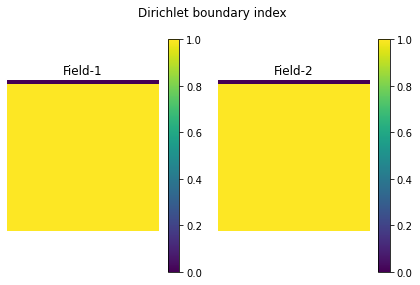

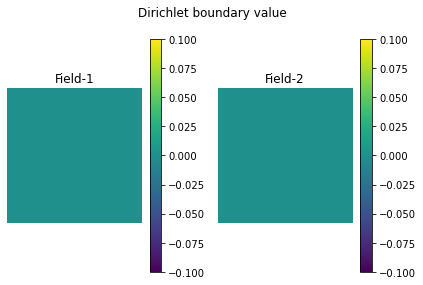

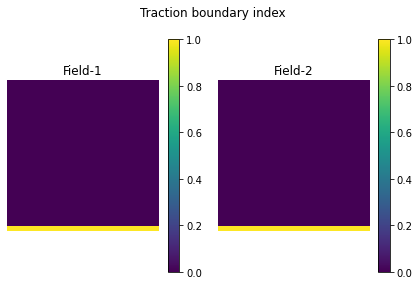

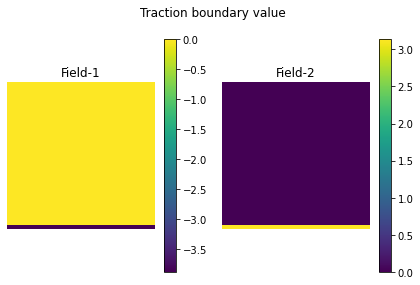

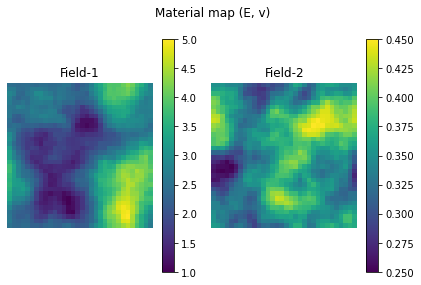

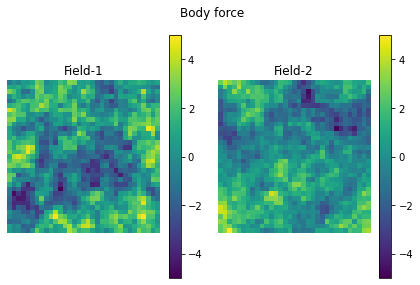

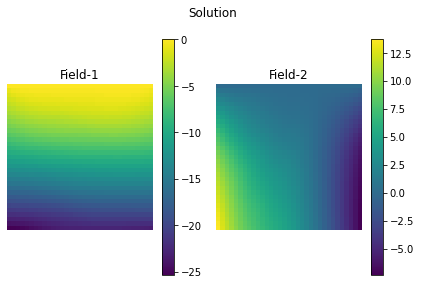

In [4]:
plot.plot_elasticfield(dirich_idx_train[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_train[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(traction_idx_train[k], ftitle='Traction boundary index')
plot.plot_elasticfield(traction_value_train[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_train[k], ftitle='Material map (E, v)')
plot.plot_elasticfield(f_train[k], ftitle='Body force')
plot.plot_elasticfield(u_train[k], ftitle='Solution')

In [5]:
domain_size = 2
n_elem = 2**5
ku, kf = 2, 2
h = domain_size/n_elem
grid = SingleGrid(domain_size, n_elem=n_elem, mode='elastic')

In [6]:
EPS = 1e-6
n_jac = 0
u_test = torch.ones(size=(bs, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double)
u_test = grid.iterator.reset_boundary(u_test, dirich_value_train, dirich_idx_train)
residual = grid.net(h, u_test, f_train, traction_value_train, traction_idx_train, material_train)
res = torch.norm(residual[:, :, 1:, :]).item() # fix top, apply traction force at bottom boundary
res_arr = [res]

while (abs(res) > EPS):
    u_test, residual = grid.iterator.jacobi_convolution(h, u_test, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, material_train)
    #residual = grid.model(h, u_test, f_train, traction_value_train, traction_idx_train, material_train)
    res = torch.norm(residual[:, :, 1:, :]).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')


0 20.162891064200263
1 9.91303447381326
2 7.1206031767782285
3 5.73603001510846
4 4.869334554979113
5 4.270112416712718
6 3.8249341627605067
7 3.480559850360003
8 3.204586242605627
9 2.9781820764707767
10 2.788516215665219
11 2.627129671367889
12 2.487898969307694
13 2.3664388284170212
14 2.2594365121488473
15 2.16438299434987
16 2.07931795697279
17 2.002697443583768
18 1.933281731420424
19 1.870066217556823
20 1.8122261400733204
21 1.7590785624186263
22 1.7100525463710123
23 1.6646671978709215
24 1.6225144128092666
25 1.5832456195949212
26 1.5465612467489926
27 1.5122023951142871
28 1.4799441318497746
29 1.4495900786575735
30 1.4209679954776517
31 1.393926160560275
32 1.3683303803424351
33 1.344061507510944
34 1.3210133686052132
35 1.2990910254452572
36 1.2782093093585996
37 1.258291579989312
38 1.239268669680972
39 1.2210779820410362
40 1.203662719105815
41 1.1869712162512591
42 1.1709563677196082
43 1.1555751286561475
44 1.1407880819796024
45 1.1265590603904236
46 1.1128548154324167

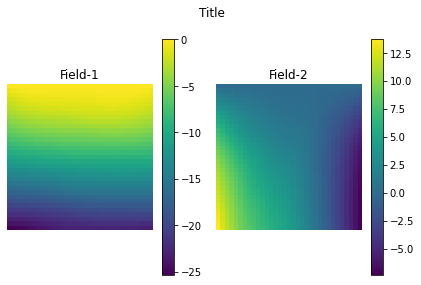

In [ ]:
plot.plot_elasticfield(u_test[0])

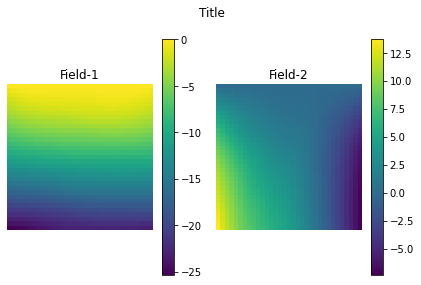

In [ ]:
plot.plot_elasticfield(u_train[0])

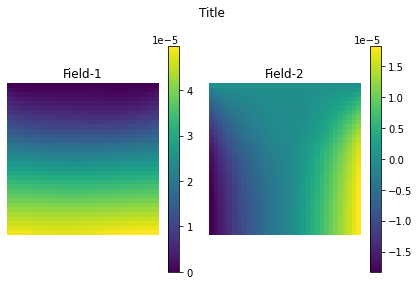

In [ ]:
plot.plot_elasticfield(u_test[0]-u_train[0])

In [ ]:
class PsiNet(nn.Module):
    def __init__(self, mode='thermal'):
        super(PsiNet, self).__init__()

        self.mode = mode
        self.km, self.ku, self.kf = 1, 1, 1 # thermal problem
        if(self.mode == 'elastic'):
            self.km, self.ku, self.kf = 2, 2, 2
            
        self.attention_map = nn.Sequential(
            nn.Conv2d(self.km, 1, kernel_size=2, padding=1),
            nn.Conv2d(1, 9*self.kf, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=9*self.kf)
            )
        self.smoother = nn.Sequential(
            nn.Conv2d(9*self.kf, self.kf, kernel_size=1, padding=0, bias=False),
            nn.Conv2d(self.kf, self.kf, kernel_size=3, padding=1, bias=False),
            nn.Conv2d(self.kf, self.ku, kernel_size=3, padding=1, bias=False)
            )

    def forward(self, x, m):
        '''
        m: material field
        x: residual input'''
        bs, ch, h, w = m.size()
        new_x = F.unfold(x, kernel_size = 3, padding = 1).view(bs, -1, h, w) # shape (bs, 9kf, h, w)
        attention = F.sigmoid(self.attention_map(m)) # shape (bs, 9kf, h, w)
        new_x = new_x * attention
        return x + self.smoother(new_x) # shape (bs, ku, h, w)

In [ ]:
class PsiIterator(nn.Module):
    def __init__(self, 
                 size=2, 
                 psi_net=None,
                 grid=None,
                 n=2**5,
                 batch_size=8,
                 max_epochs=1000,
                 mode='elastic',
                 model_dir='model/learn_iterator/'):
        super(PsiIterator, self).__init__()
        self.size = size
        self.n = n
        self.h = size/n
        self.mode = mode
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.loss = nn.MSELoss(reduction='sum')
        
        if(grid is None):
            self.grid = SingleGrid(size, n, mode='elastic', iterator='psi')
        else:
            self.grid = grid

        if(psi_net is None):
            self.psi_net = PsiNet(mode)
        else:
            self.psi_net = psi_net

        self.optimizer = torch.optim.Adadelta(self.psi_net.parameters())
        self.model_dir=model_dir+mode

    def ResetBoundary(self, u, dirich_value, dirich_idx):
        """ Reset values at the dirichlet boundary """
        return u * dirich_idx + dirich_value

    def PsiRelax(self, h, v, f, t, t_idx, d, d_idx, m, num_sweeps_down):
        '''
        Perform a fixed number of Psi iteration
        '''
        u = self.ResetBoundary(v, d, d_idx)
        for _ in range(num_sweeps_down):
            residual = self.grid.net(h, u, f, t, t_idx, m)
            u = self.psi_net(residual, m)
            u = self.ResetBoundary(u, d, d_idx)
        return u

    def RandomSampling(self, x):
        u = torch.randn_like(x)
        return u

    def TrainSingleEpoch(self, train_dataloader):
        running_loss = 0.
        for i, data in enumerate(train_dataloader):
            dirich_idx_train, dirich_value_train, traction_idx_train, traction_value_train, material_train, f_train, u_train = data
        
            self.optimizer.zero_grad() # zero the gradients for every batch
            k = 1 #random.randint(1,20)

            uu = self.RandomSampling(f_train)
            u_out = self.PsiRelax(self.h, uu, f_train, traction_value_train, traction_idx_train, dirich_value_train, dirich_idx_train, k)
            loss_i = self.loss(u_out, u_train)
            loss_i.backward()
            self.optimizer.step()
        
            running_loss += loss_i.item()
    
        last_loss = running_loss/(i+1)
        return last_loss
    
    def Train(self, training_set):
        train_dataloader = DataLoader(training_set, batch_size=self.batch_size, shuffle=True)
        loss_train = torch.zeros((self.max_epochs, 1))
        avg_loss = self.TrainSingleEpoch(train_dataloader)
        print('Step-0 loss:', avg_loss)

        for epoch in range(1, self.max_epochs):
            avg_loss = self.TrainSingleEpoch(train_dataloader)
            if(epoch % 50 == 0):
                print('Step-'+str(epoch)+' loss:', avg_loss)

            # save the model's state
            mpath = os.path.join(self.model_dir,model_name+'.pth')
            torch.save(self.psi_net.state_dict(), mpath)
            loss_train[epoch] = avg_loss
        return loss_train